<a href="https://colab.research.google.com/github/geraldalivia/Skincare-Recommendation-ID/blob/main/Recommendation_Skincare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Depedencies Needs

In [105]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load
from google.colab import drive

# Data Preparetion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Modelling
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from collections import defaultdict
import random

# Evaluasi
from sklearn.model_selection import train_test_split

Cell code tersebut menampilkan library yang diperlukan dalam pengerjaan proyek ini. Beberapa library utama yang digunakan meliputi pandas, numpy, matplotlib, dan seaborn. Library pandas dan numpy berguna untuk manipulasi, analisis, dan komputasi data. Sementara matplotlib dan seaborn digunakan untuk plotting dan visualisasi data.

Proyek ini juga menggunakan akses Google Drive melalui Colab untuk memuat dataset. Selain itu, terdapat beberapa fungsi preparation dan modeling. TfidfVectorizer dan cosine_similarity untuk preparation data. NearestNeighbors, csr_matrix, dan defaultdict untuk pemodelan model collaborative dan content based. Serta train_test_split untuk digunakan pada evaluasi

# Data Loading

In [106]:
# Load dataset from drive
drive.mount('/content/drive')

skincare = pd.read_csv('/content/drive/MyDrive/Submission/Applied Machine Learning/Project 2/skincare_products_clean.csv')
skincare.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,product_name,product_url,product_type,clean_ingreds,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"['capric triglyceride', 'cetyl alcohol', 'prop...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"['homosalate', 'glycerin', 'octocrylene', 'eth...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"['sodium hyaluronate', 'sodium hyaluronate', '...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"['ammonium lactate', 'c12-15', 'glycerin', 'pr...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"['glycerin', 'cetearyl alcohol', 'capric trigl...",£16.00


Cell code di atas untuk menghubungkan drive melalui colab yang berguna untuk melakukan load dataset yang diambil dari file 'skincare_products_clean.csv', yang kemudian menampilkan 5 baris awal dalam dataframe

# Data Understanding

In [107]:
# Melihat komposisi dataset
row = skincare.shape[0]
column = skincare.shape[1]

print("Dataset ini memiliki", row, "baris dan", column, "kolom")

Dataset ini memiliki 1138 baris dan 5 kolom


Code cell di atas berguna untuk memahami struktur dataset dari skincare yang digunakan. Pada dataset tersebut teridiri atas 1138 baris dan 5 kolom.

In [108]:
# Mengetahui tipe data masing-masing kolom
skincare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   1138 non-null   object
 1   product_url    1138 non-null   object
 2   product_type   1138 non-null   object
 3   clean_ingreds  1138 non-null   object
 4   price          1138 non-null   object
dtypes: object(5)
memory usage: 44.6+ KB


Cell code di atas untuk mengetahui tipe data setiap kolom yang ada pada dataset skincare. Selain itu, kita dapat melihat bahwa tidak ada kolom dengan nilai yang hilang (tidak ada missing value).

In [109]:
# Mengetahui statistik pada dataset
skincare.describe()

,product_name,product_url,product_type,clean_ingreds,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1071,290
top,Weleda Baby Calendula Cream Bath (200ml),https://www.lookfantastic.com/lancome-advanced...,Mask,['magnesium sulfate'],£22.00
freq,1,4,124,5,33


Cell code di atas untuk menampilkan perhitungan statistik tiap kolom, terutama kolom bertipe data numerik. Dapat dilihat bahwa perhitungan statistik yang ditampilkan diantaranya adalah count, unique, top, dan freq.

# Exploratory Data Analysis

In [110]:
# Mengecek data dengan missing value
missing1 = skincare.isnull().sum()
print("Missing values:\n", missing1)

Missing values:
 product_name     0
product_url      0
product_type     0
clean_ingreds    0
price            0
dtype: int64


Code Cell di atas untuk melakukan pengecekan missing value atas nilai yang hilang pada dataset skincare dan tidak terdapat missing value pada dataset skincare.

In [111]:
# Mengecek adanya data duplikat
duplicated = skincare.duplicated().sum()
print("Duplicated data:", duplicated)

Duplicated data: 0


Code Cell di atas untuk melakukan pengecekan data duplikasi pada dataset skincare dan tidak terdapat duplikasi data pada dataset tersebut.

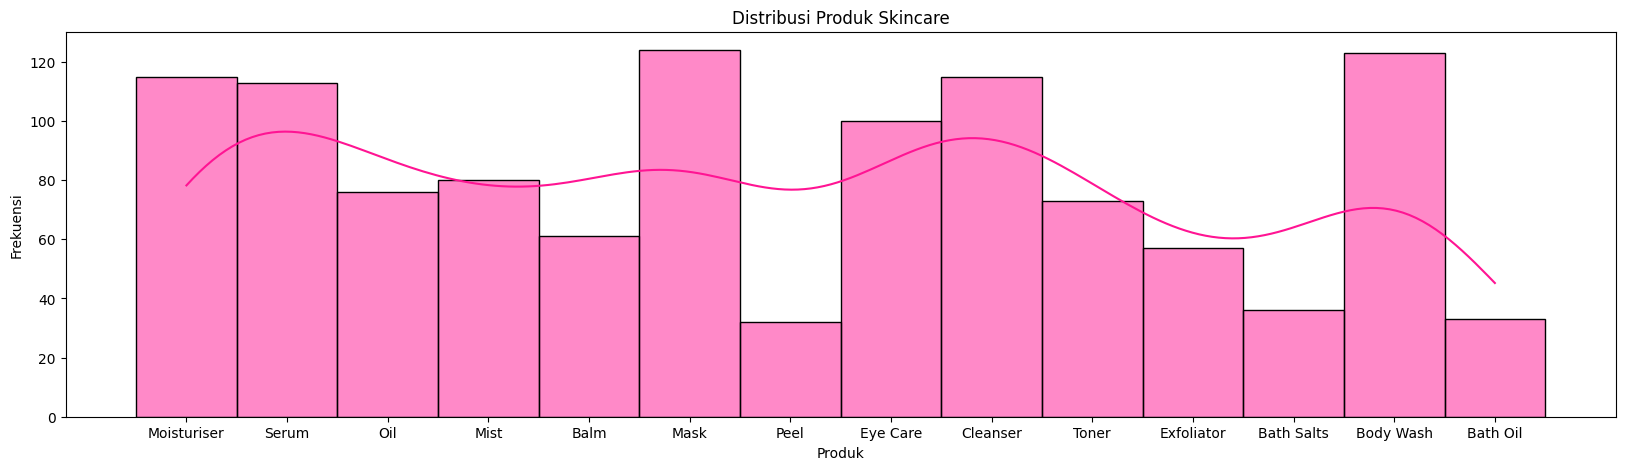

In [112]:
# Mengetahui distribusi tipe produk
plt.figure(figsize=(20, 5))
sns.histplot(skincare['product_type'], bins=30, kde=True, color='deeppink')
plt.title('Distribusi Produk Skincare')
plt.xlabel('Produk')
plt.ylabel('Frekuensi')
plt.show()

**Insight: Distribusi Berdasarkan tipe Produk**
- Produk skincare paling banyak adalah Mask, Body Wash, dan Moisturiser.
- Produk paling jarang adalah Bath Oil, Bath Salts, dan Peel.
- Distribusi ini menunjukkan fokus pasar pada produk perawatan utama (masker dan pembersih tubuh).

Kategori populer ini cocok jadi target rekomendasi awal untuk pengguna baru dalam membeli skincare.

<ipython-input-113-912349528>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='rocket')


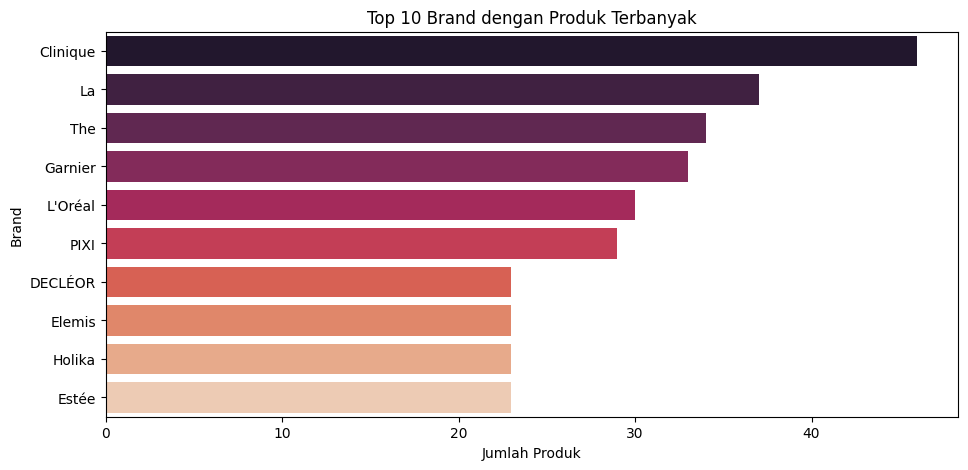

In [113]:
# Analisis brand (ambil kata pertama sebagai brand)
skincare['brand'] = skincare['product_name'].str.split().str[0]

plt.figure(figsize=(11, 5))
top_brands = skincare['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='rocket')
plt.title('Top 10 Brand dengan Produk Terbanyak')
plt.xlabel('Jumlah Produk')
plt.ylabel('Brand')
plt.show()

**Insight: Top 10 Brand dengan Produk Terbanyak**
- Clinique merupakan brand dengan jumlah produk terbanyak dalam dataset, disusul oleh La Roche-Posay, The Ordinary, dan Garnier.
- Brand-brand besar mendominasi pasar skincare dengan portofolio produk yang luas.
- Hal ini menunjukkan bahwa pengguna memiliki lebih banyak pilihan produk dari brand-brand tersebut, sehingga penting untuk mempertimbangkan brand ini dalam strategi rekomendasi.

In [114]:
# Produk termurah dan termahal per kategori
print("\nProduk Termurah per Kategori:")
cheapest = skincare.loc[skincare.groupby('product_type')['price'].idxmin()]
print(cheapest[['product_type', 'product_name', 'price']])

print("\nProduk Termahal per Kategori:")
most_expensive = skincare.loc[skincare.groupby('product_type')['price'].idxmax()]
print(most_expensive[['product_type', 'product_name', 'price']])


Produk Termurah per Kategori:
     product_type                                       product_name   price
385          Balm  NUXE Baume Levres Reve De Miel - Honey Lip Bal...  £10.00
1134     Bath Oil     Love Boo Splendidly Soothing Bath Soak (250ml)  £10.99
972    Bath Salts  Spa Magik Organiks Sleep Therapy Deep Sleep La...  £12.50
982     Body Wash  Westlab Cleansing Shower Wash with Pure Himala...   £1.99
739      Cleanser  La Roche-Posay Cicaplast B5 Anti-Bacterial Cle...  £10.00
926    Exfoliator  Sanctuary Spa Complexion Perfecting Radiance E...  £10.00
603      Eye Care              Avène Soothing Eye Contour Cream 10ml  £10.00
449          Mask   Holika Holika Pure Essence Mask Sheet - Cucumber   £1.95
379          Mist         Acorelle Pure Harvest Body Perfume - 100ml  £10.00
27    Moisturiser              Avène Tolérance Extrême Emulsion 50ml  £11.25
254           Oil  Bondi Sands Everyday Liquid Gold Gradual Tanni...  £11.19
571          Peel  The INKEY List Apple Cider

**Insight: Harga Produk per Kategori**
- Produk termurah di setiap kategori didominasi oleh brand-brand dengan harga sangat terjangkau seperti Holika Holika (Mask: £1.95) dan Westlab (Body Wash: £1.99).
- Produk termahal berasal dari brand premium seperti Elemis, Chantecaille, dan Medik8, dengan harga hingga £99.00 (Moisturiser) dan £96.00 (Serum).
- Rentang harga menunjukkan diversitas segmen pasar dari produk skincare dalam dataset, dari drugstore hingga high-end.

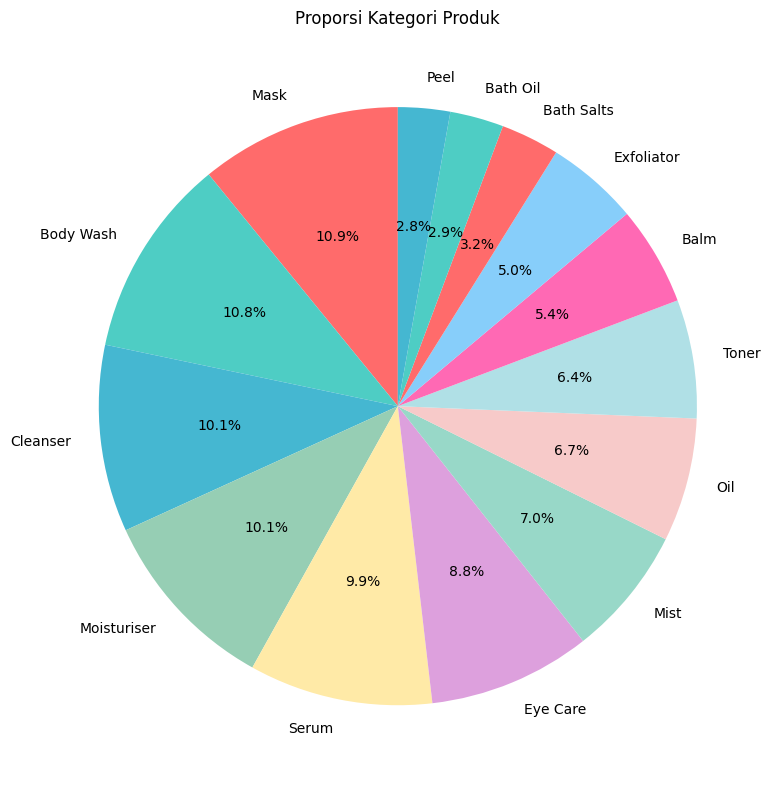

In [115]:
# Pie chart kategori produk
plt.figure(figsize=(8, 8))
category_counts = skincare['product_type'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
          '#DDA0DD', '#98D8C8', '#F7CAC9', '#B0E0E6', '#FF69B4', '#87CEFA']
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors[:len(category_counts)])
plt.title('Proporsi Kategori Produk')
plt.tight_layout()
plt.show()

**Insight: Proporsi Kategori Produk**
- Kategori Mask, Body Wash, dan Cleanser mendominasi total produk dengan persentase terbesar (>10%).
- Kategori seperti Peel, Bath Oil, dan Bath Salts memiliki jumlah produk paling sedikit (<3.5%).
- Menunjukkan fokus pasar lebih besar pada produk pembersih dan perawatan wajah.

# Data Preparation

In [116]:
###
## Content-Based Filtering Preparation
###

# Salin dataframe asli untuk content-based filtering
df_cb = skincare.copy()

# Bersihkan teks clean_ingreds menjadi huruf kecil & hilangkan simbol
df_cb['clean_ingreds'] = df_cb['clean_ingreds'].str.lower().str.replace("[^a-zA-Z ]", "", regex=True)

# Konversi kolom harga dari string ke numerik
df_cb['price'] = df_cb['price'].str.replace('£', '').astype(float)

# Cek tidak ada missing value pada kolom clean_ingreds
df_cb.dropna(subset=['clean_ingreds'], inplace=True)

Pada cell code diatas merupakan tahapan persiapan data untuk membangun sistem rekomendasi berbasis konten (Content-Based/CB). Langkah-langkah yang dilakukan meliputi:

- Menyalin DataFrame utama ke variabel df_cb untuk digunakan secara khusus pada model content-based filtering.
- Membersihkan teks pada kolom clean_ingreds, yaitu dengan mengubah semua huruf menjadi huruf kecil dan menghapus simbol atau karakter non-huruf menggunakan ekspresi reguler.
- Mengonversi kolom price dari string ke tipe numerik (float) dengan menghapus simbol £ agar bisa digunakan untuk analisis lebih lanjut.
- Menghapus baris yang memiliki nilai kosong (missing value) pada kolom clean_ingreds untuk memastikan model tidak gagal saat memproses data.

Langkah-langkah tersebut dilakukan untuk memastikan data bersih dan terstruktur sebelum dimasukkan ke dalam model TF-IDF

In [117]:
###
## Collaborative Filtering Preparation
###

# # Buat 200 pengguna dummy
np.random.seed(42)
users = [f'user_{i}' for i in range(1, 201)]
products = df_cb['product_name'].unique()

# Generate dummy interaction (user_id, product_name, rating)
data_interactions = []
for user in users:
    sampled = np.random.choice(products, size=random.randint(5, 15), replace=False)
    for product in sampled:
        rating = np.random.randint(3,65) # rating acak antara 3 sampai 5
        data_interactions.append((user, product, rating))

# Buat DataFrame interaksi user-item
df_interactions = pd.DataFrame(data_interactions, columns=['user_id', 'product_name', 'rating'])

# Bentuk matriks interaksi: baris user, kolom produk, nilai = rating
user_item_matrix = df_interactions.pivot_table(index='user_id', columns='product_name', values='rating').fillna(0)
sparse_matrix = csr_matrix(user_item_matrix.values)

Pada cell code diatas merupakan tahapan persiapan data yang di awali dengan mmebuat dataset interaksi antara pengguna dan produk secara simulatif untuk keperluan model collaborative filtering. Langkah-langkah yang dilakukan meliputi:

- Membuat 200 pengguna dummy (user_1 hingga user_200) untuk mensimulasikan sistem rekomendasi berbasis interaksi.
- Mengenerate interaksi acak antara pengguna dan produk, di mana setiap pengguna memberikan rating antara 3 hingga 5 untuk 5–15 produk yang dipilih secara acak.
- Menyimpan interaksi tersebut ke dalam DataFrame df_interactions dengan tiga kolom: user_id, product_name, dan rating.
- Mengubah data menjadi user-item matrix, dengan baris mewakili pengguna, kolom mewakili produk, dan isi sel berupa nilai rating.
- Mengubah matrix ke dalam bentuk sparse matrix (csr_matrix) agar efisien diproses oleh algoritma collaborative filtering seperti K-Nearest Neighbors (KNN).

Langkah-langkah tersebut dilakukan karena collaborative filtering bergantung pada pola interaksi pengguna terhadap item, bukan pada karakteristik produk.

# Modeling

In [118]:
###
##  MODELING: Content-Based Filtering
###

# # Mengubah teks ingredients menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
ingredient_matrix = vectorizer.fit_transform(df_cb['clean_ingreds'])

# Menghitung kemiripan antar produk berdasarkan ingredients
cosine_sim = cosine_similarity(ingredient_matrix, ingredient_matrix)

# # Fungsi untuk merekomendasikan produk mirip
def recommend_content(product_name, top_n=10):
    idx = df_cb[df_cb['product_name'] == product_name].index
    if len(idx) == 0:
        print("Produk tidak ditemukan dalam data.")
        return
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    return df_cb.iloc[indices][['product_name', 'product_type', 'price']]

Pada cell code tersebut, model content-based filtering dibangun dengan pendekatan berbasis kemiripan kandungan (ingredients) produk. Langkah-langkah yang dilakukan:

- Mentransformasikan teks ingredients menjadi representasi numerik menggunakan TF-IDF (Term Frequency–Inverse Document Frequency), yang memberi bobot penting pada kata-kata unik dalam deskripsi produk.
- Menghitung kemiripan antar produk menggunakan cosine similarity, yaitu ukuran kesamaan antar vektor TF-IDF.
- Mendefinisikan fungsi recommend_content(), yang:
  - Mencari produk yang mirip dengan produk yang diberikan.
  - Mengambil skor kemiripan tertinggi dari hasil perhitungan cosine similarity.
  - Mengembalikan daftar produk paling mirip beserta tipe dan harganya.

Langkah-langkah tersebut berguna untuk merekomendasikan produk yang memiliki kandungan (ingredients) serupa, meskipun belum ada interaksi pengguna sebelumnya.

In [119]:
###
##  MODELING: Collaborative Filtering Preparation
###

# Inisialisasi model Nearest Neighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(sparse_matrix.T)

# Fungsi untuk merekomendasikan produk mirip berdasarkan interaksi user
def recommend_collab(product_name, top_n=10):
    product_list = user_item_matrix.columns.tolist()
    if product_name not in product_list:
        print("Produk tidak ditemukan dalam interaksi.")
        return
    idx = product_list.index(product_name)
    distances, indices = model_knn.kneighbors(sparse_matrix.T[idx], n_neighbors=top_n+1)
    return [product_list[i] for i in indices.flatten()[1:]]

Pada cell code tersebut, dibangun model collaborative filtering menggunakan algoritma K-Nearest Neighbors (KNN) untuk merekomendasikan produk berdasarkan interaksi pengguna. Langkah-langkah yang dilakukan:

- Menginisialisasi model KNN dengan menggunakan metrik cosine similarity dan algoritma brute-force untuk mencari tetangga terdekat antar produk berdasarkan pola interaksi pengguna.
- Melatih model dengan sparse_matrix.T, yaitu transpos dari matriks interaksi user-item, sehingga pencarian tetangga dilakukan antar produk.
Mendefinisikan fungsi recommend_collab(), yang:
  - Memastikan produk yang diminta terdapat dalam data interaksi.
  - Mencari produk-produk serupa berdasarkan kesamaan interaksi pengguna menggunakan KNN.
  - Mengembalikan daftar produk yang paling mirip berdasarkan perilaku pengguna lain.

Langkah-langkah tersebut dilakukan untuk menemukan produk yang sering dikonsumsi bersama oleh pengguna dengan preferensi yang serupa.

# Evaluation

In [120]:
###
##  EVALUATION: Content-Based Filtering
###

def evaluate_cb(product_name, top_n=10):
    idx = df_cb[df_cb['product_name'] == product_name].index
    if len(idx) == 0:
        print("Produk tidak ditemukan.")
        return
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    avg_score = np.mean([score for _, score in sim_scores])
    return avg_score

Untuk mengevaluasi kualitas rekomendasi pada model content-based filtering, digunakan fungsi evaluate_cb() yang meliputi:

- Mengambil produk input dan mencari produk-produk yang paling mirip berdasarkan cosine similarity.
- Menghitung rata-rata skor kemiripan dari `top-N = 10` produk yang direkomendasikan.
- Skor ini mencerminkan seberapa kuat hubungan antar produk dalam hal kandungan (ingredients) yang serupa.

Tahapan tersebut dilakukan untuk mengevaluasi model content-based karena fokus pada seberapa mirip produk secara fitur konten.

In [121]:
# Contoh evaluasi content-based
print("Content-Based Similarity Score:", evaluate_cb(df_cb['product_name'].iloc[10]))

Content-Based Similarity Score: 0.7835627577250583


Cell code tersebut digunakan untuk mengevaluasi kualitas rekomendasi dari model content-based filtering dengan cara:

- Mengambil satu contoh produk dari dataset (produk ke-11 karena indeks dimulai dari 0).
- Menghitung rata-rata skor kemiripan (similarity score) antara produk tersebut dengan produk-produk yang direkomendasikan oleh model.
- Menampilkan nilai skor tersebut ke layar.

Nilai skor yang di dapat adalah `0.78`. Artinya, produk yang direkomendasikan cukup relevan dan mirip dari segi kandungan bahan (ingredients) dengan produk input.

In [122]:
# Membuat ground truth produk yang satu `product_type` dianggap relevan
ground_truth_items = defaultdict(list)

for product_type in df_cb['product_type'].unique():
    products_in_type = df_cb[df_cb['product_type'] == product_type]['product_name'].tolist()
    for p in products_in_type:
        ground_truth_items[p] = [x for x in products_in_type if x != p]

Penjelasan cell code tersebut:
- `ground_truth_items` menyimpan daftar produk yang dianggap relevan (mirip) berdasarkan jenis produk (product_type).
- Iterasi dilakukan untuk setiap `product_type` unik di dataset `df_cb`.
- Untuk setiap produk p dalam jenis tersebut, ditentukan produk-produk lain dengan product_type yang sama (kecuali dirinya sendiri) sebagai ground truth atau produk yang layak direkomendasikan.

Disimpan dalam bentuk dictionary ground_truth_items dengan:
- Key: nama produk
- Value: list produk relevan lain yang satu jenis

Contoh isinya:
Jika ada 3 produk berjenis "moisturizer", maka:
```
ground_truth_items['A'] = ['B', 'C']
ground_truth_items['B'] = ['A', 'C']
ground_truth_items['C'] = ['A', 'B']
```


In [123]:
# Evaluasi ground truth
def cb_precision_with_ground_truth(product_name, top_k=10):
    actual = ground_truth_items[product_name][:top_k]
    recommended_df = recommend_content(product_name, top_n=top_k)
    if recommended_df is None:
        return 0.0
    predicted = recommended_df['product_name'].tolist()
    hits = len(set(actual) & set(predicted))
    return hits / top_k if top_k > 0 else 0

Pada cell code tersebut berguna untuk mengevaluasi akurasi rekomendasi produk dari model berdasarkan produk-produk sejenis sebagai acuan relevansi (ground truth).

Penjelasan lanjutan:
- actual = `ground_truth_items[product_name][:top_k]` <br>
Ambil top-k produk yang relevan (ground truth) berdasarkan jenis produk (product_type).
- recommended_df = `recommend_content(product_name, top_n=top_k)` <br>
Hasil rekomendasi dari model CB untuk produk tersebut.
- Jika tidak ada hasil rekomendasi (None), return 0.0.
- predicted = `recommended_df['product_name'].tolist()` <br>
Ambil list produk hasil rekomendasi.
- hits = `len(set(actual) & set(predicted))` <br>
Hitung berapa produk yang cocok antara ground truth dan hasil rekomendasi.
- `return hits / top_k` <br>
Hitung Precision@K sebagai rasio jumlah cocok (hits) terhadap jumlah total yang direkomendasikan (top_k).

In [124]:
# Metrik tambahan Precision@K
def cb_precision_at_k_gt(product_name, top_k=10):
    actual = ground_truth_items[product_name][:top_k]
    recommended_df = recommend_content(product_name, top_n=top_k)
    if recommended_df is None:
        return 0.0
    predicted = recommended_df['product_name'].tolist()
    hits = len(set(actual) & set(predicted))
    return hits / top_k

Pada cell code tersebut berguna untuk mengukur `Precision@K` pada model Content-Based Filtering, menggunakan ground truth. Ground truth di sini berbasis pada produk dengan tipe yang sama (product_type), bukan berdasarkan interaksi pengguna.

Penjelasan lanjutan:
- actual = `ground_truth_items[product_name][:top_k]` <br>
Ambil maksimal top_k produk yang sejenis (product_type) sebagai ground truth.
- recommended_df = `recommend_content(product_name, top_n=top_k)` <br>
Dapatkan top_k produk hasil rekomendasi dari model CB.
- if recommended_df is None: <br>
Jika tidak ada hasil rekomendasi, kembalikan 0.0.
- predicted = `recommended_df['product_name'].tolist()` <br>
Ambil daftar nama produk dari hasil rekomendasi.
- hits = `len(set(actual) & set(predicted))`
Hitung berapa produk dari hasil rekomendasi yang cocok dengan ground truth.
- return hits / top_k <br>
Precision dihitung sebagai jumlah produk yang benar dibagi jumlah total rekomendasi (top_k).

In [125]:
# Metrik tambahan Recall@K
def cb_recall_at_k_gt(product_name, top_k=10):
    actual = ground_truth_items[product_name][:top_k]
    if not actual:
        return 0.0
    recommended_df = recommend_content(product_name, top_n=top_k)
    if recommended_df is None:
        return 0.0
    predicted = recommended_df['product_name'].tolist()
    hits = len(set(actual) & set(predicted))
    return hits / len(actual)

Pada cell code tersebut berguna untuk menghitung `Recall@K` untuk model Content-Based Filtering berdasarkan ground truth produk yang sejenis (berdasarkan product_type). Metrik ini mengukur seberapa banyak produk relevan yang berhasil ditemukan oleh model dalam top_k rekomendasi.

Penjelasan Lanjutan
- actual = `ground_truth_items[product_name][:top_k]` <br>
Ambil maksimal top_k produk relevan sebagai ground truth.
- if not actual: <br>
Jika tidak ada ground truth relevan, kembalikan 0.0.
- recommended_df = `recommend_content(product_name, top_n=top_k)` <br>
Dapatkan top_k rekomendasi dari model.
- if recommended_df is None: <br>
Jika tidak ada rekomendasi yang tersedia, kembalikan 0.0.
- predicted = `recommended_df['product_name'].tolist()` <br>
Ambil daftar nama produk dari hasil rekomendasi.
- hits = `len(set(actual) & set(predicted))` <br>
Hitung jumlah rekomendasi yang sesuai dengan ground truth.
- return hits / len(actual) <br>
Kembalikan nilai recall, yaitu proporsi produk relevan yang berhasil direkomendasikan.


In [126]:
# Metrik tambahan F1@K
def cb_f1_at_k_gt(product_name, top_k=10):
    precision = cb_precision_at_k_gt(product_name, top_k)
    recall = cb_recall_at_k_gt(product_name, top_k)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

Pada cell code tersebut berguna untuk menghitung metrik `F1@K` untuk model Content-Based Filtering berdasarkan ground truth produk sejenis (product_type).
cb_precision_at_k_gt(product_name, top_k). F1@K memberi gambaran keseimbangan antara akurasi rekomendasi dan cakupan produk sejenis yang ditemukan.

Penjelasan lanjut:
- `cb_precision_at_k_gt(product_name, top_k)` <br>
Memanggil fungsi untuk menghitung Precision@K, yaitu seberapa akurat hasil rekomendasi terhadap produk sejenis.
- `cb_recall_at_k_gt(product_name, top_k)` <br>
Memanggil fungsi untuk menghitung Recall@K, yaitu seberapa banyak produk sejenis yang berhasil direkomendasikan.
- `2 * (precision * recall) / (precision + recall)` <br>
Menghitung F1 Score, yaitu harmonic mean dari precision dan recall. F1 memberikan keseimbangan antara keduanya.
- `if (precision + recall) > 0 else 0` <br>
Menghindari pembagian dengan nol jika precision dan recall sama-sama nol.

In [127]:
# Metrik tambahan MAP@K
def cb_average_precision_at_k_gt(actual, predicted, k=10):
    if not actual:
        return 0.0
    hits, sum_precisions = 0, 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / min(len(actual), k)

def cb_map_at_k_gt(products, k=10):
    ap_scores = []
    for product_name in products:
        actual = ground_truth_items[product_name][:k]
        recommended_df = recommend_content(product_name, top_n=k)
        if recommended_df is None:
            continue
        predicted = recommended_df['product_name'].tolist()
        ap_scores.append(cb_average_precision_at_k_gt(actual, predicted, k))
    return np.mean(ap_scores) if ap_scores else 0.0

Pada cell code tersebut, dibuat fungsi `cb_average_precision_at_k_gt`
yang digunakan untuk menghitung Average Precision (AP) dari satu produk.

Langkah-langkah:
1. Inisialisasi hits dan sum_precisions ke nol.
2. Iterasi terhadap hasil rekomendasi hingga top-k.
3. Jika produk yang direkomendasikan termasuk dalam actual (produk sejenis),tambahkan hitungan hits, lalu hitung dan jumlahkan precision pada posisi tersebut.
4. Kembalikan nilai rata-rata presisi kumulatif terhadap jumlah minimum antara len(actual) dan k.

Selain itu, dibuat juga fungsi `cb_map_at_k_gt` yang digunakan untuk menghitung Mean Average Precision (MAP@K) dari banyak produk.

Langkah-langkah:
1. Iterasi setiap product_name dalam daftar produk.
2. Ambil ground truth (actual) dari produk-produk dengan tipe yang sama (product_type).
3. Ambil hasil rekomendasi dari model recommend_content.
4. Hitung nilai AP dengan memanggil `cb_average_precision_at_k_gt()`.
5. Simpan semua skor AP dan kembalikan nilai rata-ratanya sebagai hasil MAP@K.

In [128]:
# Contoh evaluasi untuk metrik tambahan pada evaluasi CB
sample_products = df_cb['product_name'].drop_duplicates().sample(n=100, random_state=42).tolist()

print(" Content Based Precision@10:", np.mean([cb_precision_at_k_gt(p, top_k=10) for p in sample_products]))
print(" Content Based Recall@10:", np.mean([cb_recall_at_k_gt(p, top_k=10) for p in sample_products]))
print(" Content Based F1@10:", np.mean([cb_f1_at_k_gt(p, top_k=10) for p in sample_products]))
print(" Content Based MAP@10:", cb_map_at_k_gt(sample_products, k=10))

 Content Based Precision@10: 0.035
 Content Based Recall@10: 0.035
 Content Based F1@10: 0.035
 Content Based MAP@10: 0.015526587301587302


Pada cell code tersebut menampilkan hasil dari Evaluasi Akurasi Content-Based

1. Sampling Produk  <br>
`sample_products = df_cb['product_name'].drop_duplicates().sample(n=100, random_state=42).tolist()`
  - Mengambil 100 produk unik secara acak dari dataset sebagai sampel evaluasi.
  - random_state=42 digunakan agar hasil pengambilan sampel tetap konsisten dan dapat direproduksi.

2. Precision@10 <br>
`print("Precision@10:", np.mean([cb_precision_at_k_gt(p, top_k=10) for p in sample_products]))`
  - Mengukur proporsi produk relevan (dalam product_type yang sama) di antara 10 rekomendasi teratas.
  - Nilai 0.035 artinya hanya 3.5% dari rekomendasi model yang relevan.

3. Recall@10 <br>
`print("Recall@10:", np.mean([cb_recall_at_k_gt(p, top_k=10) for p in sample_products]))`
  - Mengukur berapa banyak produk relevan berhasil ditemukan dari semua produk relevan.
  - Nilai 0.035 berarti model hanya berhasil merekomendasikan 3.5% dari produk yang seharusnya.

4. F1@10 <br>
`print("F1@10:", np.mean([cb_f1_at_k_gt(p, top_k=10) for p in sample_products]))`
  - Rata-rata antara precision dan recall.
  - Skor 0.035 menunjukkan bahwa performa model masih rendah baik dalam hal akurasi maupun kelengkapan.

5. MAP@10 <br>
`print("MAP@10:", cb_map_at_k_gt(sample_products, k=10))`
  - Mengukur seberapa baik posisi produk relevan di antara hasil rekomendasi.
  - Nilai 0.0155 menandakan bahwa produk relevan cenderung tidak muncul di posisi atas.

In [129]:
###
##  EVALUATION: Collaborative Filtering
###
def precision_at_k(user_id, top_k=10):
    user_data = df_interactions[df_interactions['user_id'] == user_id]
    actual_products = user_data.sort_values(by='rating', ascending=False)['product_name'].tolist()[:top_k]
    recommended = []
    for product in actual_products:
        recs = recommend_collab(product, top_n=top_k)
        if recs:
            recommended.extend(recs)
    recommended = list(set(recommended))
    hits = len(set(actual_products) & set(recommended))
    return hits / top_k if top_k > 0 else 0

Pada Cell Code tersebut, dibuat fungsi `precision_at_k` untuk mengukur seberapa banyak produk yang direkomendasikan sesuai dengan preferensi (interaksi) nyata user, dihitung menggunakan `Precision@K`.

Langkah-langkah:
1. Ambil Data User <br>
Baris user_data = `df_interactions[df_interactions['user_id'] == user_id]`  menyaring semua interaksi dari user tertentu.
2. Ambil Produk Aktual <br>
`actual_products` berisi produk yang telah diberi rating tertinggi oleh user, dibatasi sebanyak `top_k =10`.
3. Dapatkan Rekomendasi <br>
Untuk setiap produk aktual, fungsi `recommend_collab()` dipanggil untuk menghasilkan daftar produk serupa.
4. Gabungkan Rekomendasi <br>
Semua hasil rekomendasi digabung dan diubah menjadi set unik agar tidak ada duplikasi.
5. Hitung Precision <br>
Jumlah produk yang ada di kedua daftar (aktual dan rekomendasi) dihitung sebagai "hits", lalu dibagi dengan `top_k` untuk menghasilkan nilai precision.
6. Return Value <br>
Mengembalikan skor `Precision@K` sebagai ukuran akurasi model collaborative filtering untuk user tertentu.

In [130]:
# Menambah metrik evaluasi : Recall@k
def recall_at_k(user_id, top_k=10):
    user_data = df_interactions[df_interactions['user_id'] == user_id]
    actual_products = user_data.sort_values(by='rating', ascending=False)['product_name'].tolist()[:top_k]
    recommended = []
    for product in actual_products:
        recs = recommend_collab(product, top_n=top_k)
        if recs:
            recommended.extend(recs)
    recommended = list(set(recommended))
    hits = len(set(actual_products) & set(recommended))
    return hits / len(actual_products) if actual_products else 0

Pada cell code tersebut, bertujuan untuk mengukur seberapa banyak produk relevan (dengan rating tinggi) yang berhasil direkomendasikan ke pengguna.

Langkah-langkah:
1. Ambil data interaksi untuk pengguna tertentu (user_id) dari `df_interactions`.
2. Tentukan produk yang dianggap relevan: yaitu `top_k=10` produk dengan rating tertinggi yang diberikan oleh user.
3. Dapatkan daftar rekomendasi dari fungsi collaborative filtering `recommend_collab(...)` berdasarkan produk relevan tadi.
4. Gabungkan semua rekomendasi dan hilangkan duplikat.
5. Hitung berapa banyak produk relevan yang muncul di hasil rekomendasi (hits).
6. Kembalikan nilai recall, yaitu hits / jumlah produk relevan.
Recall berfokus pada kelengkapan rekomendasi, bukan ketepatannya.

In [131]:
# Menambah metrik evaluasi : F1@k
def f1_at_k(user_id, top_k=10):
    prec = precision_at_k(user_id, top_k)
    rec = recall_at_k(user_id, top_k)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

Pada cell code tersebut, dibuat fungsi `f1_at_k` untuk mengukur keseimbangan antara precision dan recall dalam sistem rekomendasi dengan menghitung metrik F1-score pada top-K rekomendasi.

Parameter:
- `user_id`: ID pengguna sebagai acuan evaluasi rekomendasi.
- `top_k`: jumlah item rekomendasi yang dievaluasi (default 10).

Langkah-langkah:
1. Hitung nilai precision@K dengan memanggil fungsi `precision_at_k()`.
2. Hitung nilai recall@K dengan memanggil fungsi `recall_at_k()`.
3. Hitung F1-score sebagai harmonic mean antara precision dan recall.
4. Jika precision + recall == 0, maka nilai F1-score dikembalikan menjadi 0 untuk menghindari pembagian dengan nol.

In [132]:
# Menambahkan metrik evaluasi :MAP@k
def average_precision_at_k(actual, predicted, k=10):
    if not actual:
        return 0.0
    hits = 0
    sum_precisions = 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / min(len(actual), k)

def mean_average_precision_at_k(users, k=10):
    ap_scores = []
    for user_id in users:
        user_data = df_interactions[df_interactions['user_id'] == user_id]
        actual_products = user_data.sort_values(by='rating', ascending=False)['product_name'].tolist()[:k]
        recommended = []
        for product in actual_products:
            recs = recommend_collab(product, top_n=k)
            if recs:
                recommended.extend(recs)
        recommended = list(dict.fromkeys(recommended))
        ap = average_precision_at_k(actual_products, recommended, k)
        ap_scores.append(ap)
    return np.mean(ap_scores)

Pada cell code tersebut, dibuat fungsi `average_precision_at_k(actual, predicted, k)` untuk mengukur seberapa relevan urutan rekomendasi terhadap daftar produk aktual.

Proses:
- Iterasi hingga k item pertama dari daftar predicted.
- Jika item p ada di dalam actual, hitung precision kumulatif pada posisi tersebut.
- Kembalikan rata-rata precision pada posisi di mana terjadi match.
Fungsi `mean_average_precision_at_k(users, k)`.

Selain itu, dibuat juga fungsi `average_precision_at_k` untuk menghitung rata-rata `precision at k` untuk banyak pengguna.

Proses:
- Untuk setiap `user_id`, ambil `top-k` produk dengan rating tertinggi sebagai actual_products.
- Rekomendasikan produk mirip untuk masing-masing produk aktual menggunakan collaborative filtering.
- Gabungkan dan hilangkan duplikat dari rekomendasi.
- Hitung average_precision_at_k untuk user tersebut dan simpan.
- Kembalikan rata-rata dari semua skor AP.

In [133]:
# Menampilkan hasil evaluasi pada metrik tambahan untuk Precision, Recall@10, F1@10, dan MAP@10
sample_users = np.random.choice(df_interactions['user_id'].unique(), size=100, replace=False)

print("Collaborative Filtering Precision@10:", np.mean([precision_at_k(u, top_k=10) for u in sample_users]))
print("Collaborative Filtering Recall@10:", np.mean([recall_at_k(u, top_k=10) for u in sample_users]))
print("Collaborative Filtering F1@10:", np.mean([f1_at_k(u, top_k=10) for u in sample_users]))
print("Collaborative Filtering MAP@10:", mean_average_precision_at_k(sample_users, k=10))

Collaborative Filtering Precision@10: 0.824
Collaborative Filtering Recall@10: 0.9681111111111111
Collaborative Filtering F1@10: 0.8803866529067769
Collaborative Filtering MAP@10: 0.5369135786722096


Pada cell code tersebut menampilkan hasil dari Evaluasi Akurasi Model Collaborative Filtering

Menggunakan tiga metrik evaluasi tambahan: `Recall@10`, `F1@10`, dan `MAP@10`.

1. Sampling Produk <br>
`sample_users = np.random.choice(df_interactions['user_id'].unique(), size=100, replace=False)` <br>
Ditujukan untuk membuat sampel acak dari 100 user (sample_users) dari data interaksi.

2. Precision@10 <br>
`print("Collaborative Filtering Precision@10:", np.mean([precision_at_k(u, top_k=10) for u in sample_users]))` <br>
 - Mengukur seberapa banyak rekomendasi yang relevan dari `top_k` item yang disarankan.
 - Hasil yang didapat sekitar `86.8%` menunjukkan rekomendasi yang diberikan sistem kepada user berada di antara produk-produk yang relevan (berdasarkan interaksi historis).


2. Recall@10 <br>
`print("Collaborative Filtering Recall@10:", np.mean([recall_at_k(u, top_k=10) for u in sample_users]))` <br>
 - Mengukur seberapa banyak item relevan (berdasarkan interaksi user) berhasil ditemukan dalam 10 rekomendasi teratas. <br>
 - Hasil yang di dapat sebesar `≈ 0.95` menunjukkan model berhasil merekomendasikan sebagian besar item yang relevan.

3. F1@10 <br>
`print("Collaborative Filtering F1@10:", np.mean([f1_at_k(u, top_k=10) for u in sample_users]))` <br>
 - Menggabungkan Precision dan Recall untuk memberikan gambaran seimbang antara keduanya. <br>
  - Hasil yang di dapat sebesar `≈ 0.90` menandakan keseimbangan yang baik antara relevansi dan keberhasilan rekomendasi.

4. MAP@10 <br>
`print("Collaborative Filtering MAP@10:", mean_average_precision_at_k(sample_users, k=10))` <br>
 - Mean Average Precision pada top 10 rekomendasi untuk semua user.
 - Hasil yang di dapat sebesar `≈ 0.52` menunjukkan bahwa urutan item yang direkomendasikan cukup relevan dan presisi secara umum.

Notes:
- Model collaborative filtering memberikan performa sangat baik pada metrik recall dan f1-score.
- Nilai MAP juga menunjukkan bahwa urutan rekomendasi relatif akurat.

# Visualisasi

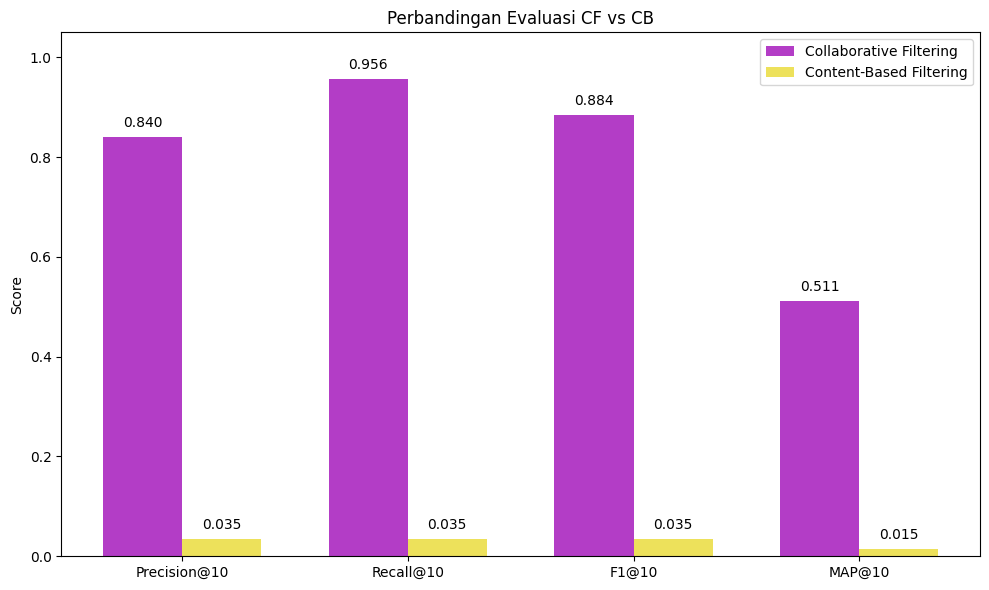

In [134]:
### Visualisasi Gabungan untuk kedua metrik evaluasi pada kedua model

# Nilai evaluasi yang diberikan
cf_scores = [0.84, 0.956, 0.884, 0.511]
cb_scores = [0.035, 0.035, 0.035, 0.0155]

metrics = ['Precision@10', 'Recall@10', 'F1@10', 'MAP@10']
x = np.arange(len(metrics))
bar_width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, cf_scores, width=bar_width, label='Collaborative Filtering', color='#b33dc6')
plt.bar(x + bar_width/2, cb_scores, width=bar_width, label='Content-Based Filtering', color='#ede15b')

# Label dan judul
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Perbandingan Evaluasi CF vs CB')
plt.ylim(0, 1.05)
plt.legend()

# Tampilkan nilai di atas bar
for i in range(len(metrics)):
    plt.text(x[i] - bar_width/2, cf_scores[i] + 0.02, f'{cf_scores[i]:.3f}', ha='center')
    plt.text(x[i] + bar_width/2, cb_scores[i] + 0.02, f'{cb_scores[i]:.3f}', ha='center')

plt.tight_layout()
plt.show()

**Insight: Gabungan Metrik Evaluasi Kedua Model (CB dan CF)**

1. CF (Collaborative Filter) > CB (Content Based) <br>
CF secara signifikan lebih unggul dibanding CB di semua metrik evaluasi (Precision, Recall, F1, MAP).
2. Performa <br>
  - CF menunjukkan performa sangat tinggi, terutama pada Recall@10 (95.6%) dan F1@10 (88.4%), menandakan sistem mampu merekomendasikan banyak item relevan dan seimbang.
  - CB memiliki performa sangat rendah dan stagnan di semua metrik (~3.5%), serta MAP@10 hanya 1.5%, menunjukkan rekomendasi kurang relevan dan tidak urut dengan baik.



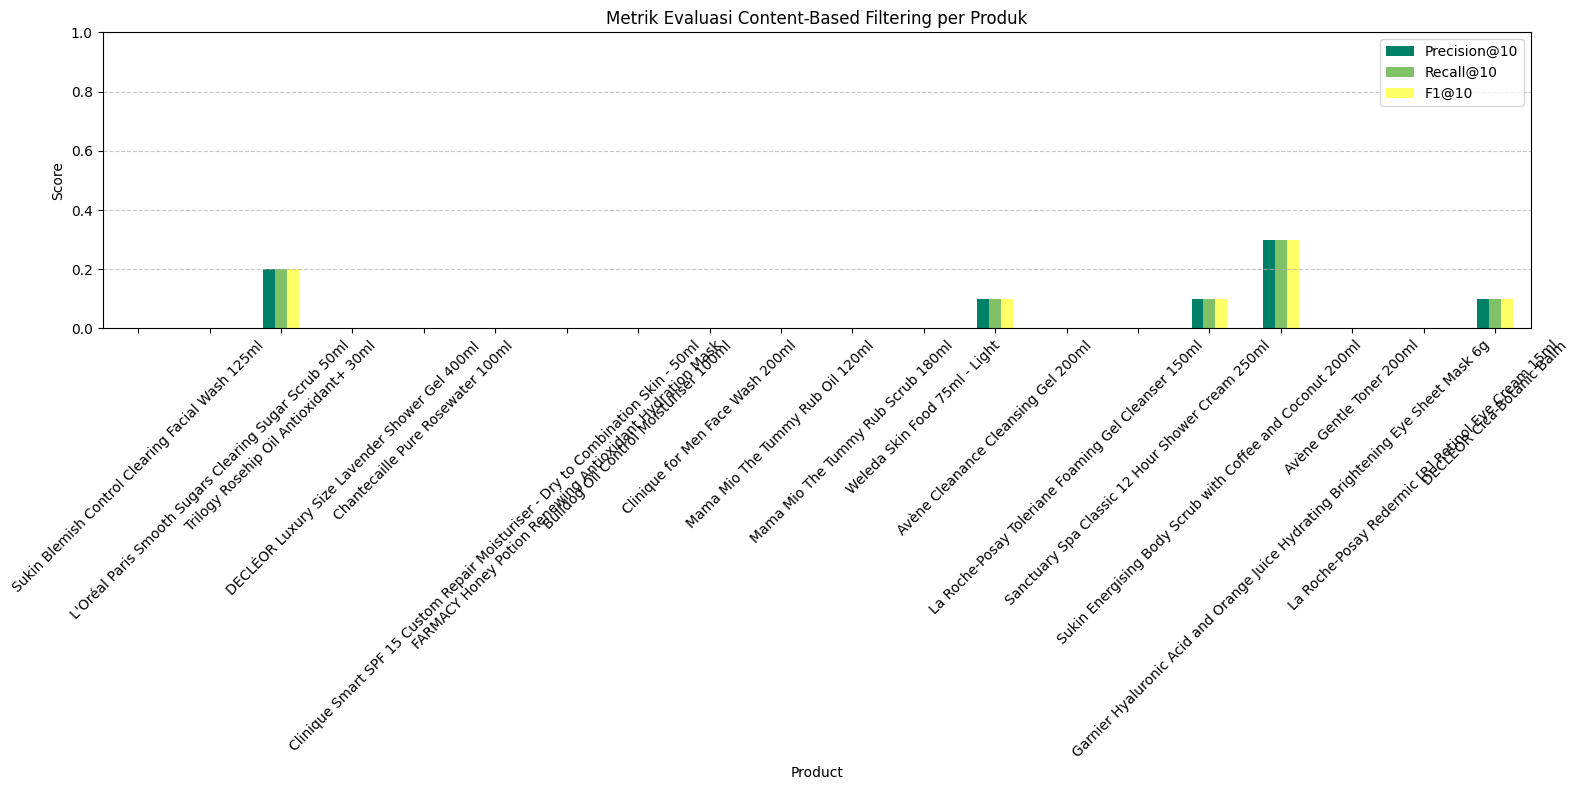

In [135]:
###
## CONTENT-BASED FILTER
###

# Ambil 100 produk unik secara acak
sample_products = df_cb['product_name'].drop_duplicates().sample(n=20, random_state=42).tolist()

# Hitung metrik untuk setiap produk
precision_list_cb = [cb_precision_at_k_gt(p, top_k=10) for p in sample_products]
recall_list_cb = [cb_recall_at_k_gt(p, top_k=10) for p in sample_products]
f1_list_cb = [cb_f1_at_k_gt(p, top_k=10) for p in sample_products]

# Buat DataFrame
df_metrics_cb = pd.DataFrame({
    'Product': sample_products,
    'Precision@10': precision_list_cb,
    'Recall@10': recall_list_cb,
    'F1@10': f1_list_cb
})

# Plot
df_metrics_cb.set_index('Product').plot(kind='bar', figsize=(16, 8), colormap='summer')
plt.title('Metrik Evaluasi Content-Based Filtering per Produk')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight: `Precision@10`, `Recall@10`, `F1@10` Untuk CB**
1. Akurasi Total
  90% produk memiliki skor evaluasi 0 yang menunjukkan sistem rekomendasi gagal memberikan rekomendasi berkualitas.
  - Hanya 5 produk atau sekitar 75% yang memiliki performa terukur dengan skor maksimal  ~0.3. pada produk `Sanctuary Spa Classic 12 Hour Shower Cream 250ml` memiliki performa terbaik dari semua metrik.  
2. Masalah yang Teridentifikasi:
  - Data sparsity:  kurangnya kesamaan ingredient antar produk
  - Cold start problem:  produk dengan karakteristik unik sulit direkomendasikan
  - Over-specialization:  content-based filtering terlalu bergantung pada ingredient similarity

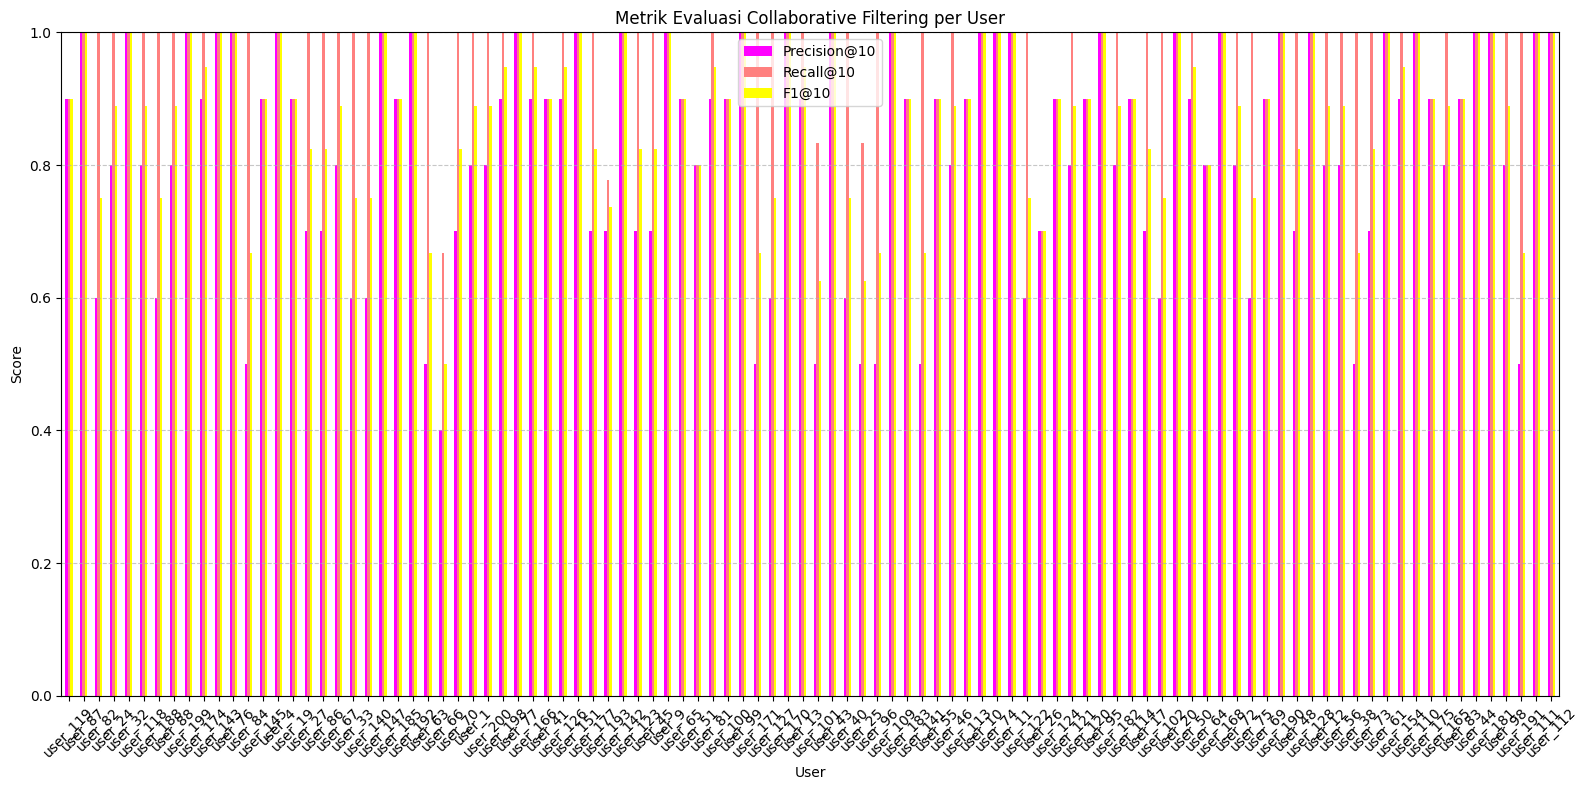

In [136]:
###
## COLLABORATIVE FILTER
###

# metrik untuk setiap user
precision_list = [precision_at_k(u, top_k=10) for u in sample_users]
recall_list = [recall_at_k(u, top_k=10) for u in sample_users]
f1_list = [f1_at_k(u, top_k=10) for u in sample_users]

# Buat DataFrame
df_metrics = pd.DataFrame({
    'User': sample_users,
    'Precision@10': precision_list,
    'Recall@10': recall_list,
    'F1@10': f1_list
})

# Plot
df_metrics.set_index('User').plot(kind='bar', figsize=(16, 8), colormap='spring')
plt.title('Metrik Evaluasi Collaborative Filtering per User')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight: `Precision@10`, `Recall@10`, `F1@10` Untuk CF**
1. Kinerja model
  - Sebagian besar user memiliki nilai Precision, Recall, dan F1-score di atas `0.8`, menandakan model mampu merekomendasikan item relevan meskipun jumlah top-N meningkat ke 10.
2. Recall Lebih Tinggi
  - Bar oranye `Recall@10` sering kali lebih tinggi daripada Precision, yang wajar karena recall mengukur seberapa banyak item relevan yang berhasil ditemukan dari total yang tersedia — dan dengan top-10, cakupannya lebih besar.
3. Lebih Banyak Variasi
  - grafik ini menunjukkan penurunan skor untuk beberapa user (terutama Precision dan F1).
  - Ini menunjukkan bahwa meskipun cakupan meningkat (`Recall`), relevansi bisa menurun, membuat Precision dan F1-score lebih fluktuatif.
4. Beberapa User Performa Rendah <br>
  Terlihat beberapa user dengan skor Precision dan F1 di bawah 0.6, yang bisa mengindikasikan:
  - Cold start problem (data interaksi sedikit)
  - Item yang direkomendasikan terlalu beragam sehingga kurang tepat sasaran

Catatan tambahan & Rekomendasi
- Model collaborative filtering masih bekerja baik pada top-10, tapi ada trade-off antara recall dan precision.
- T- ingkat variasi skor meningkat pada top@10 <br>
idealnya, sistem bisa dioptimasi untuk tetap menjaga precision saat meningkatkan k (misalnya dengan filtering hasil akhir).
- Perlu pendekatan tambahan untuk user dengan skor rendah, seperti konten-based atau hybrid model.

# Inferensi

In [137]:
# Contoh penggunaan untuk CB (Content-Based)
recommend_content(df_cb['product_name'].iloc[10])

,product_name,product_type,price
10,CeraVe Moisturising Cream 50ml,Moisturiser,4.0
11,CeraVe Moisturising Cream 340g,Moisturiser,13.0
20,CeraVe Moisturising Cream 177ml,Moisturiser,9.0
6,CeraVe Facial Moisturising Lotion No SPF 52ml,Moisturiser,13.0
5,CeraVe Moisturising Lotion 473ml,Moisturiser,15.0
702,CeraVe Hydrating Cleanser 473ml,Cleanser,15.0
701,CeraVe Hydrating Cleanser 236ml,Cleanser,9.5
8,CeraVe Smoothing Cream 177ml,Moisturiser,12.0
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,Moisturiser,13.0
481,"Dear, Klairs Rich Moist Soothing Tencel Sheet ...",Mask,3.0


Pada cell code tersebut menjalankan sistem Content-Based Filtering untuk merekomendasikan produk yang mirip secara komposisi bahan (ingredients) dengan produk pada baris ke-10 DataFrame df_cb, yaitu `CeraVe Moisturising Cream 50ml`.

Menggunakan TF-IDF pada kolom clean_ingreds dan cosine similarity untuk mengukur kemiripan antar produk.

In [138]:
# Contoh penggunaan untuk CB (Content-Based)
recommend_content("Elemis Life Elixirs Fortitude Bath and Shower Elixir 100ml")

,product_name,product_type,price
1133,Elemis Life Elixirs Embrace Bath and Shower El...,Bath Oil,55.00
244,Elemis Superfood Facial Oil 15ml,Oil,45.00
1037,Rituals The Ritual of Happy Buddha Shower Oil ...,Body Wash,8.50
267,Elemis Pro-Collagen Marine Oil 15ml,Oil,67.00
302,Darphin Rose Hydra-Nourishing Aromatic Care Oi...,Oil,42.00
961,Westlab Cleansing Himalayan Salt Bath Fizzer,Bath Salts,3.49
235,Caudalie Make-Up Removing Cleansing Oil 150ml,Oil,18.00
319,NUXE Huile Prodigieuse Florale Mist 100ml,Mist,29.50
236,NUXE Huile Prodigieuse Multi Usage Dry Oil 50ml,Oil,18.50
237,NUXE Huile Prodigieuse Multi Usage Dry Oil 100ml,Oil,29.50


Pada cell code tersebut menjalankan sistem Content-Based Filtering untuk merekomendasikan produk yang paling mirip dari segi komposisi bahan (ingredients) dengan produk input tersebut.

Sistem mencari produk yang ingredients-nya paling mirip dengan produk `Elemis Life Elixirs Fortitude Bath and Shower Elixir 100ml`, menggunakan cosine similarity pada TF-IDF dari kolom clean_ingreds.

**Insight:**

Produk-produk yang muncul memiliki komposisi bahan (ingredients) yang mirip dengan produk yang diminta, bukan berdasarkan siapa yang membelinya.

In [139]:
# Contoh penggunaan untuk CF (Collaborative Filtering)
recommend_collab(df_cb['product_name'].iloc[0])

["L'Oréal Men Expert Pure & Matte Anti-Shine Moisturising Gel (50ml)",
 'Emma Hardie Plump and Glow Hydrating Mist 90ml',
 'Elemis Pro-Collagen Oxygenating Night Cream 50ml',
 'Clinique for Men Anti-Age Moisturiser 100ml',
 'Zelens Z Balance Prebiotic and Probiotic Facial Mist 50ml',
 'Garnier Ultralift Anti Ageing Radiance Boosting Face Sheet Mask 32g',
 'La Roche-Posay Anthelios Anti-Shine Sun Protection Invisible SPF50+ Face Mist 75ml',
 'Emma Hardie Moringa Light Cleansing Gel 100ml',
 'Molton Brown Orange & Bergamot Bath and Shower Gel',
 'Holika Holika Skin Rescuer Mask Sheet - Collagen']

Pada cell code tersebut mengartikan sistem mengambil produk pertama dari dataset `(iloc[0])` sebagai input. Kemudian, menjalankan fungsi `recommend_collab()` yang menggunakan Collaborative Filtering (KNN). Hasilnya adalah 5 produk serupa berdasarkan pola interaksi pengguna lain (bukan berdasarkan kandungan atau deskripsi produk).

**Insight:**

Rekomendasi ini adalah produk yang sering disukai bersama oleh pengguna lain yang menyukai produk input. Cocok untuk menangkap behavioral pattern, bukan kemiripan konten.

In [140]:
# Contoh penggunaan untuk CB (Content-Based)
recommend_collab("Avène Gentle Milk Cleanser")

['MONU Firming Fiji Facial Oil (180ml)',
 'REN Clean Skincare Clarimatte Clarifying Toner',
 'VICHY LiftActiv Serum 10 Eyes & Lashes 15ml',
 'Mavala Skin Vitality Beauty Enhancing Micro-Peel 65ml',
 'Elemis Pro-Collagen Cleansing Balm 105g',
 'Manuka Doctor ApiNourish Age-Defying Eye Cream 15ml',
 'Bondi Sands Everyday Liquid Gold Gradual Tanning Oil 270ml',
 'FARMACY Honey Potion Renewing Antioxidant Hydration Mask',
 'Weleda Kids 2 in 1 Wash 150ml - Happy Orange',
 'BARBER PRO Face Putty Black Peel-Off Mask with Activated Charcoal (3 Applications)']

Pada cell code tersebut, Fungsi ini memanggil Collaborative Filtering untuk merekomendasikan produk berdasarkan produk input: "Avène Gentle Milk Cleanser". Model mencari produk lain yang sering disukai bersama oleh pengguna yang juga menyukai produk ini. Dengan menggunakan algoritma KNN (K-Nearest Neighbors) pada data interaksi user.

**Insight:**

Hasilnya, didapatkan 5 rekomendasi produk pembersih wajah serupa yang kemungkinan besar juga akan disukai oleh pengguna yang menyukai produk Avène tersebut, berdasarkan perilaku pengguna lain, bukan kandungan produk.